# Signature Verification

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utilities

In [ ]:
# showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# plotting data
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None, should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self, index):
        # TODO: need to update how images are chosen
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        # need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                # keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                # keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Siamese Network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn1 = nn.Sequential( 
        nn.Conv2d(1, 96, kernel_size=11, stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3, stride=2),

        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),

        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3))

        # defining the fully connected layers
        self.fc1 = nn.Sequential(
        # first dense layer
        nn.Linear(25600, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),
        # second dense layer
        nn.Linear(1024, 128),
        nn.ReLU(inplace=True),
        # final dense layer
        nn.Linear(128, 2))

    def forward_once(self, x):
        # forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        # returning the feature vectors of two inputs
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # find the pairwise distance or eucledian distance of two output feature vectors
        euclidean_distance = F.pairwise_distance(output1, output2)
        # perform contrastive loss calculation with the distance
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Training

In [ ]:
# config

train_dataset_dir = datasets.ImageFolder(root="/content/drive/MyDrive/sign_data/train")
test_dataset_dir = datasets.ImageFolder(root="/content/drive/MyDrive/sign_data/test")

# train_dataset_dir = datasets.ImageFolder(root="./custom_sign_data/original")
# test_dataset_dir = datasets.ImageFolder(root="./custom_sign_data/forged")

train_batch_size = 64
train_number_epochs = 100

In [ ]:
train_dataset = SiameseNetworkDataset(imageFolderDataset=train_dataset_dir, 
                                      transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                      should_invert=False)

In [ ]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        #num_workers=8,
                        batch_size=train_batch_size)

In [ ]:
def train():
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    print('Device state:', device)
    
    net = SiameseNetwork().to(device)
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(), lr = 0.004)
    
    counter = []
    loss_history = [] 
    iteration_number = 0
    
    for epoch in range(0, train_number_epochs):
        for i, data in enumerate(train_dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
            if i % 10 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

    show_plot(counter,loss_history)
    return net

Device state: cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch number 0
 Current loss 1.745603322982788

Epoch number 0
 Current loss 1.352674961090088

Epoch number 0
 Current loss 1.3088266849517822

Epoch number 1
 Current loss 1.3343088626861572

Epoch number 1
 Current loss 1.4610073566436768

Epoch number 1
 Current loss 1.2284419536590576

Epoch number 2
 Current loss 1.2136985063552856

Epoch number 2
 Current loss 1.15156888961792

Epoch number 2
 Current loss 1.2578617334365845

Epoch number 3
 Current loss 1.2565727233886719

Epoch number 3
 Current loss 1.1951825618743896

Epoch number 3
 Current loss 1.2834718227386475

Epoch number 4
 Current loss 1.1130900382995605

Epoch number 4
 Current loss 1.4219717979431152

Epoch number 4
 Current loss 1.462719202041626

Epoch number 5
 Current loss 1.1687355041503906

Epoch number 5
 Current loss 1.1861340999603271

Epoch number 5
 Current loss 1.2626140117645264

Epoch number 6
 Current loss 1.2953248023986816

Epoch number 6
 Current loss 1.235334038734436

Epoch number 6
 Current lo

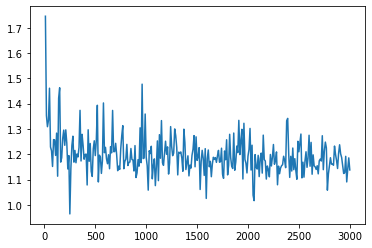

Model saved successfully


In [ ]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model saved successfully")

In [ ]:
# Load the saved model 
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("model.pt"))

In [ ]:
test_dataset = SiameseNetworkDataset(imageFolderDataset=test_dataset_dir,
                                     transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]),
                                     should_invert=False)

In [ ]:
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Device state: cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


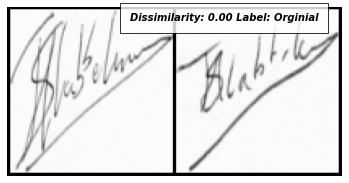

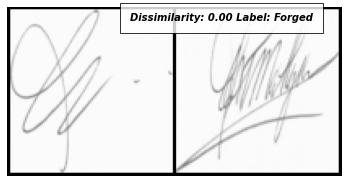

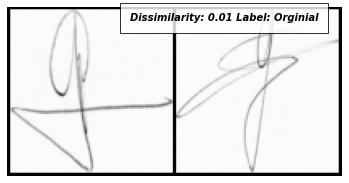

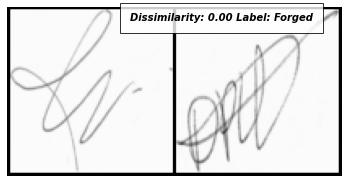

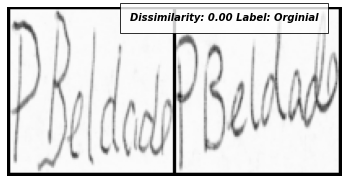

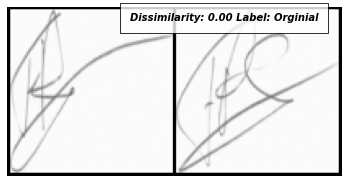

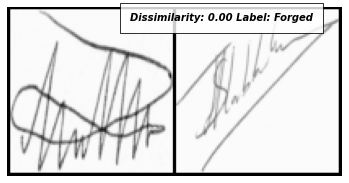

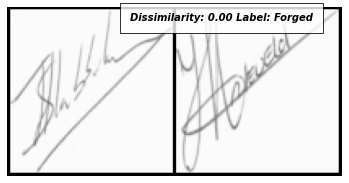

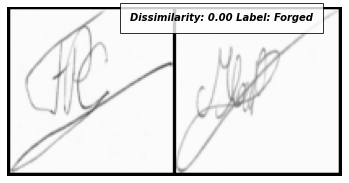

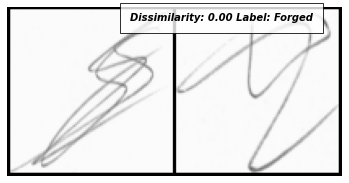

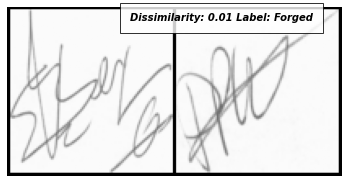

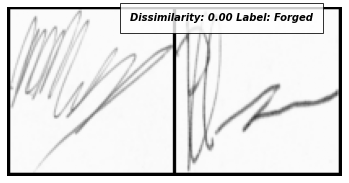

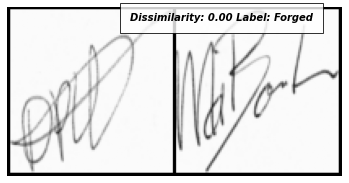

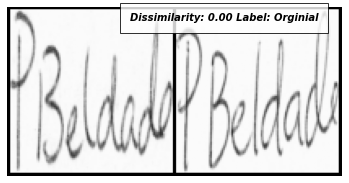

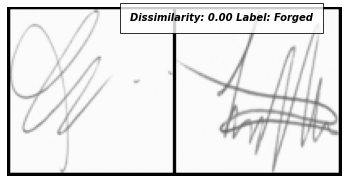

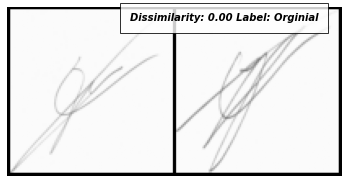

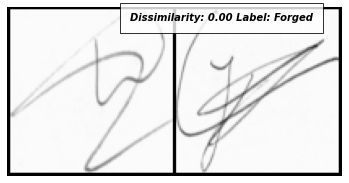

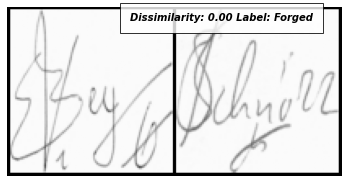

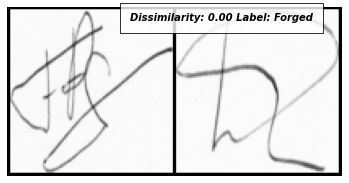

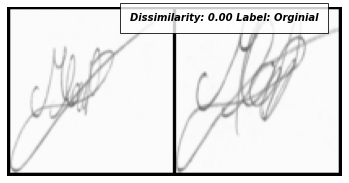

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)
net = SiameseNetwork().to(device)

counter = 0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])

for i, data in enumerate(test_dataloader, 0): 
    x0, x1, label = data
    concatenated = torch.cat((x0, x1), 0)
    output1, output2 = net(x0.cuda(), x1.cuda())
    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if label == list_0:
        label = "Orginial"
    else: 
        label = "Forged"
        
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter = counter+1
    if counter == 20:
        break